## Using Siphon to query the NetCDF Subset Service and plotting it to a map
##### This example uses Siphon's NCSS class to provide temperature data for contouring a basic map using Cartopy

First we construct a TDSCatalog instance pointing to our dataset of interest, in
this case TDS' "Best" virtual dataset for the GFS global 0.25 degree collection of
GRIB files. This will give us a good resolution for our map. This catalog contains a single dataset.

In [1]:
%matplotlib inline
from siphon.catalog import TDSCatalog
best_gfs = TDSCatalog('http://thredds-jumbo.unidata.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p25deg/catalog.xml?dataset=grib/NCEP/GFS/Global_0p25deg/Best')
best_gfs.datasets

{'Best GFS Quarter Degree Forecast Time Series': <siphon.catalog.Dataset at 0x108bf1278>}

We pull out this dataset and look at the access urls.

In [2]:
best_ds = list(best_gfs.datasets.values())[0]
best_ds.access_urls

{'CdmRemote': 'http://thredds-jumbo.unidata.ucar.edu/thredds/cdmremote/grib/NCEP/GFS/Global_0p25deg/Best',
 'ISO': 'http://thredds-jumbo.unidata.ucar.edu/thredds/iso/grib/NCEP/GFS/Global_0p25deg/Best',
 'NCML': 'http://thredds-jumbo.unidata.ucar.edu/thredds/ncml/grib/NCEP/GFS/Global_0p25deg/Best',
 'NetcdfSubset': 'http://thredds-jumbo.unidata.ucar.edu/thredds/ncss/grib/NCEP/GFS/Global_0p25deg/Best',
 'OPENDAP': 'http://thredds-jumbo.unidata.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_0p25deg/Best',
 'UDDC': 'http://thredds-jumbo.unidata.ucar.edu/thredds/uddc/grib/NCEP/GFS/Global_0p25deg/Best',
 'WCS': 'http://thredds-jumbo.unidata.ucar.edu/thredds/wcs/grib/NCEP/GFS/Global_0p25deg/Best',
 'WMS': 'http://thredds-jumbo.unidata.ucar.edu/thredds/wms/grib/NCEP/GFS/Global_0p25deg/Best'}

Note the `NetcdfSubset` entry, which we will use with our NCSS class.

In [3]:
from siphon.ncss import NCSS
ncss = NCSS(best_ds.access_urls['NetcdfSubset'])

We can then use the `ncss` object to create a new query object, which
facilitates asking for data from the server.

In [4]:
query = ncss.query()

We construct a query asking for data corresponding to a latitude and longitude box where 43 lat is the northern extent, 35 lat is the southern extent, 260 long is the western extent and 249 is the eastern extent. Note that longitude values are the longitude distance from the prime meridian. We request the data for the current time.
We also ask for NetCDF version 4 data, for the variable 'temperature_surface'. This request will return all surface temperatures for points in our bounding box for a single time. Note the string representation of the query is a properly encoded query string.

In [5]:
from datetime import datetime
query.lonlat_box(43, 35, 260, 249).time(datetime.utcnow())
query.accept('netcdf4')
query.variables('Temperature_surface')

var=Temperature_surface&time=2015-07-14T03%3A34%3A53.844821&west=249&north=43&east=260&south=35&accept=netcdf4

We now request data from the server using this query. The `NCSS` class handles parsing this NetCDF data (using the `netCDF4` module). If we print out the variable names, we see our requested variables, as well as a few others (more metadata information)

In [6]:
data = ncss.get_data(query)
list(data.variables.keys())

['Temperature_surface', 'reftime1', 'time1', 'lat', 'lon']

We'll pull out the useful variables for temperature, latitude, and longitude, and time (which is the time, in hours since the forecast run). 

In [7]:
temp_3d = data.variables['Temperature_surface']
time_1d = data.variables['time1']
lat_1d = data.variables['lat']
lon_1d = data.variables['lon']

Now we make our data suitable for plotting.

In [8]:
import numpy as np
from netCDF4 import num2date

# Reduce the dimensions of the data
temp_2d = temp_3d[:].squeeze()
lat_1d = lat_1d[:].squeeze()
lon_1d = lon_1d[:].squeeze()

# Convert the number of hours since the reference time to an actual date
time_val = num2date(time_1d[:].squeeze(), time_1d.units)

# Convert temps to Fahrenheit from Kelvin
temp_2d = (temp_2d *(9.0/5.0)) - 459.67

# Combine latitude and longitudes 
lon_2d, lat_2d = np.meshgrid(lon_1d, lat_1d)

# Flatten() combines all the lists from meshgrid into one list
full_lat_1d = lat_2d.flatten()
full_lon_1d = lon_2d.flatten()

# Create one list that pairs longs and lats
lonlat_list = zip(full_lon_1d, full_lat_1d)


Now we can plot these up using matplotlib.

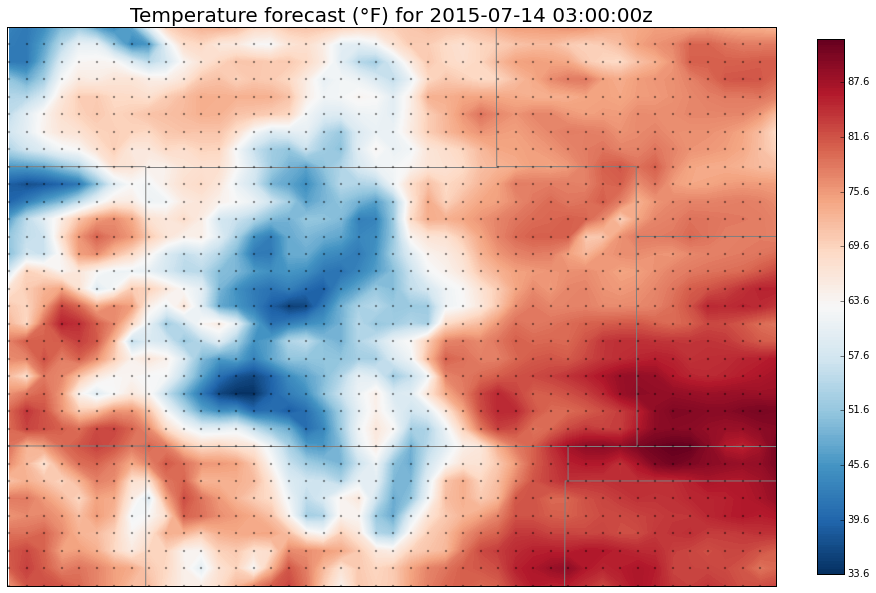

In [9]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from metpy.plots import ctables

# Create a new figure
fig = plt.figure(figsize=(15, 12))

# Add the map and set the extent
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-100.03, -111.03, 35, 43])

# Retrieve the state boundaries using cFeature and add to plot
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax.add_feature(states_provinces, edgecolor='gray')

# Contour temperature at each lat/long
plt.contourf(lon_2d, lat_2d, temp_2d, 200, transform=ccrs.PlateCarree(),
             cmap='RdBu_r')
#Plot a colorbar to show temperature and reduce the size of it
plt.colorbar(fraction=0.032)

# Make a title with the time value
plt.title('Temperature forecast ' + '(' + u'\u00b0' + 'F)' + ' for '  + str(time_val) + 'z', fontsize=20)
# Plot markers for each lat/long to show grid points for 0.25 deg GFS
for lon, lat  in lonlat_list:
    plt.plot(lon, lat, marker='o', color='black', markersize=2,
             alpha=0.3, transform=ccrs.Geodetic())